# Create module

In [ ]:
pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.1 MB/s eta 0:00:00


AttributeError: module 'keras.utils.generic_utils' has no attribute 'get_custom_objects'

In [ ]:
!pip install tensorflow==2.6.4
import tensorflow as tf
print(tf.__version__)

In [ ]:
import keras
print(keras.__version__)

2.11.0


In [ ]:
!pip install keras==2.10.0
import keras
print(keras.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.10.0


In [ ]:
import segmentation_models as sm
from segmentation_models.utils import set_trainable
from keras.preprocessing.image import ImageDataGenerator

## error
#from keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers import Adam, SGD

# AttributeError: module 'keras.utils' has no attribute 'get_file' using segmentation_models
sm.set_framework("tf.keras")
sm.framework()

## Using function in this notebook
#from model import *
#from data import *

import numpy as np
import os
import glob
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, CSVLogger

Segmentation Models: using `keras` framework.


In [ ]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available 1


In [ ]:
def adjustData(img, mask, flag_multi_class, num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask >= 0.5] = 1
        mask[mask < 0.5] = 0
    return (img,mask)

In [ ]:
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.07,
                    height_shift_range=0.07,
                    shear_range=0.07,
                    zoom_range=0.07,
                    horizontal_flip=True,
                    fill_mode='nearest')

## To check
#batch_size = 2
#train_samples = 330
#test_samples = 37
#steps_p_epoch = int(train_samples / batch_size)
#val_steps = int(test_samples / batch_size)

nr_epochs = 50 #50

In [ ]:
#from skimage.io import imread, imsave

def makeGenerator(data_frame, batch_size, folder_path, img_folder, mask_folder,
                  aug_dict, image_color_mode = "grayscale",
                  mask_color_mode = "grayscale", image_save_prefix = "image", mask_save_prefix = "mask",
                  flag_multi_class = False, num_class = 2, save_to_dir = None, target_size = (256, 256),
                  seed = 42, isTrainGenerator = True):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    If isTrainGenerator True will use aug_dict and make data aumentation
    '''

    #print("\nfolder_path", folder_path)
    #!pwd
    #!ls

    if (isTrainGenerator):
        image_datagen = ImageDataGenerator(**aug_dict)
        mask_datagen = ImageDataGenerator(**aug_dict)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        folder_path + img_folder,
        x_col = 'filename',
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        folder_path + mask_folder,
        x_col = 'filename',
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    make_generator = zip(image_generator, mask_generator)
    for (img, mask) in make_generator:
        #print("img, mask")
        #!dir

        #print("img", img)
        #print(type(img))
        #print(img.dtype)
        #print(img.shape)
        #print(mask.shape)

        #img2 = img[0, :, :, :]
        #print(img2.shape)

        #mask2 = mask[0, :, :, :]
        #print(mask2.shape)

        #imsave("img.png", img2, check_contrast=False)
        #imsave("mask.png", mask2, check_contrast=False)

        img, mask = adjustData(img, mask, flag_multi_class, num_class)
        yield(img, mask)


In [ ]:
#def load_model(DECODER, BACKBONE, input_shape, encoder_weights, encoder_freeze, classes, activation):
def load_model(DECODER, model_args):
    #model = sm.Unet(
    #model = sm.Linknet(
    #model = sm.PSPNet(

    #    backbone_name=BACKBONE, input_shape=(x, x, 3), encoder_weights='imagenet',
    #    encoder_freeze=True, classes=1, activation='sigmoid'
    #)

    ## input_shape – shape of input data/image (H, W, C)
        # Unet and Linknet - H and W of input images should be divisible by factor 32.
        # PSPNet - H and W should be divisible by 6 * downsample_factor and NOT None! - downsample_factor = 8

    if DECODER == "Unet" :
        print("\n1 DECODER:", DECODER)
        model = sm.Unet(**model_args)

    elif DECODER == "Linknet":
        print("\n2 DECODER:", DECODER)
        model = sm.Linknet(**model_args)

    elif DECODER == "PSPNet" :
        print("\n3 DECODER:", DECODER)
        model = sm.PSPNet(**model_args)
    else :
        raise ValueError("Error DECODER:", DECODER)

    return model

# To Check

## To check

## Seed in def makeGenerator() diff to train and test
    ###Status = OK

## Seed in def makeGenerator()
    batch_size = 2
    train_samples = len(train_index) # 330
    test_samples = len(test_index) # 37
    steps_p_epoch = int(train_samples / batch_size)
    val_steps = int(test_samples / batch_size)
    ### Status = OK

## Add fold in file name
    ### Status = To check

## Run code with GPU
    in env deeplearning-py37 has GPU support
    If update/install the package jupyter lost the support
    ### Status = To check


# Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Define model
#DECODER = "Unet"
#DECODER = "Linknet"
DECODER = "PSPNet"

if DECODER == "Unet":
    file_name_1='unet_f_model.png'
    file_name_2='unet_model.png'
elif DECODER == "Linknet":
    file_name_1='linknet_f_model.png'
    file_name_2='linknet_model.png'
elif DECODER == "PSPNet":
    file_name_1='pspnet_f_model_.png'
    file_name_2='pspnet_model_.png'
else:
    print("Error!")


In [ ]:
## Define model
#DECODER = "Unet"
#DECODER = "Linknet"
#DECODER = "PSPNet"

#path = "/media/sda2/home/j/Downloads/tests/recortes_tmp/"
#path = "E:/Backes/Segmentacao Linha Plantio CNN/Recortes/"

#path = "/content/drive/MyDrive/UFU João Mestrado/dataset/Recortes/"
path = "/content/drive/MyDrive/UFU João Mestrado/tests/Segmentacao Linha Plantio CNN/Recortes/"

path2="/content/drive/MyDrive/UFU João Mestrado/tests/jocival_linha_plantio_run_08_03_22/"

dataset_img_folder = "Base_A"
#dataset_img_folder = "Base_B"
#dataset_img_folder = "Base_C"
#dataset_img_folder = "Base_D"

dataset_mask_folder = dataset_img_folder + "_mask"

folds = 10

resultFolder = "results/" + dataset_img_folder + '/'
resultFolder = path2 + "results/" + dataset_img_folder + '/'

#save_trans_path = "transformation" #save_to_dir = None
save_trans_path = None

BACKBONE = "vgg16"

import pandas as pd
from sklearn.model_selection import KFold

#files = sorted(glob.glob(os.path.join(path + dataset_img_folder, "*.png")))
files = sorted([os.path.basename(x) for x in glob.glob(os.path.join(path + dataset_img_folder, "*.png"))])
#for name in files:
#    print(name)

#The first n_samples % n_splits folds have size n_samples // n_splits + 1,
#other folds have size n_samples // n_splits, where n_samples is the number of samples
kf = KFold(n_splits = folds, random_state = 42, shuffle = True)

nr_fold = 1 #1
fold_to_jump = 0 #0

for train_index, test_index in kf.split(files):
    #print("\nTRAIN:", train_index, "\n\nTEST:", test_index)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]

    if (nr_fold <= fold_to_jump):
        print("\n\nFold: - nothing to do", nr_fold, end = '')
        nr_fold = nr_fold + 1
        continue

    train_list_files = []
    for it in train_index:
        train_list_files.append(files[it])

    test_list_files = []
    for it in test_index:
        test_list_files.append(files[it])

    ## To check
    batch_size = 2
    train_samples = len(train_index)
    test_samples = len(test_index)
    steps_p_epoch = int(train_samples / batch_size)
    val_steps = int(test_samples / batch_size)

    print("\nFold:", nr_fold, end = '')
    print(" len(train_index):", len(train_index), "len(test_index):", len(test_index))

    print("\nbatch_size", batch_size)
    print("train_samples", train_samples)
    print("test_samples", test_samples)
    print("steps_p_epoch", steps_p_epoch)
    print("val_steps", val_steps)

    train_data_frame = pd.DataFrame(train_list_files, columns = ['filename'])
    test_data_frame = pd.DataFrame(test_list_files, columns = ['filename'])
    #print("\ntrain_data_frame\n", train_data_frame, "\n\ntest_data_frame\n", test_data_frame)

    preprocess_input = sm.get_preprocessing(BACKBONE)

    # size - target_size?: 240 PSPNet, 256 Unet and Linknet, 288 All
    if DECODER == "Unet" or DECODER == "Linknet":
        size = 256 # 240 # 256 # 288 ## target_size
    elif DECODER == "PSPNet":
        size = 240 # 8 and 4

        ## Test
        #size = 288 # 16
    else:
        raise ValueError("Error DECODER:", DECODER)

    print("\ntarget_size:", size, size)

    trainGene = makeGenerator(train_data_frame, batch_size, path, dataset_img_folder, dataset_mask_folder,
                              aug_dict = data_gen_args, save_to_dir = save_trans_path, image_color_mode = "rgb",
                              isTrainGenerator = True, target_size = (size, size))

    testGene = makeGenerator(test_data_frame, batch_size, path, dataset_img_folder, dataset_mask_folder,
                             aug_dict = '', save_to_dir = save_trans_path, image_color_mode = "rgb",
                             isTrainGenerator = False, target_size = (size, size))

    ## input_shape – shape of input data/image (H, W, C)
        # Unet and Linknet - H and W of input images should be divisible by factor 32.
        # PSPNet - H and W should be divisible by 6 * downsample_factor and NOT None! - downsample_factor = 8

    ## add input_shape = (size, size, 3) beacuse PSPNet

    #data_load_model_args = dict(backbone_name = BACKBONE, input_shape = (size, size, 3),
    #                            encoder_weights='imagenet', encoder_freeze = True,
    #                            classes = 1, activation = 'sigmoid')

    #data_load_model_args = dict(backbone_name = BACKBONE, input_shape = (size, size, 3),
    #                            encoder_weights='imagenet', encoder_freeze = False,
    #                            classes = 1, activation = 'sigmoid')

    data_load_model_args = dict(backbone_name = BACKBONE, input_shape = (size, size, 3),
                                encoder_weights=None, encoder_freeze = False,
                                classes = 1, activation = 'sigmoid')

    ## Test
    data_load_model_args = dict(backbone_name = BACKBONE, input_shape = (size, size, 3),
                                encoder_weights=None, encoder_freeze = False, downsample_factor = 8, # 4, 8, 16
                                classes = 1, activation = 'sigmoid')

    model = load_model(DECODER, data_load_model_args)

    if nr_fold == 1:
        model.summary()
        #input()

    #model = sm.Unet(
    #model = sm.Linknet(
    #model = sm.PSPNet(
    #model = sm.PSPNet(backbone_name=BACKBONE, input_shape=(240, 240, 3),
    #model = sm.PSPNet(backbone_name=BACKBONE, input_shape=(288, 288, 3),

    #model = sm.Unet(
    #model = sm.Linknet(
    #model = sm.PSPNet(
        #backbone_name=BACKBONE, input_shape=(x, x, 3),
        #encoder_weights='imagenet',
        #encoder_freeze=True,
        #classes=1,
        #activation='sigmoid'
    #)

    opt = Adam(learning_rate = 1e-3)

#    model.compile(opt,
#        loss=sm.losses.jaccard_loss,
#        metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.precision]
#    )

    csv_logger = CSVLogger(resultFolder + BACKBONE + "_" + DECODER  + "_" + dataset_img_folder + ".csv", append=True)

    model_checkpoint = ModelCheckpoint(resultFolder + BACKBONE + "_" + DECODER + "_" +
                dataset_img_folder + "_" + str(nr_fold) + ".hdf5", monitor = "loss", verbose = 1, save_best_only=True)

    history = model.fit_generator(generator = trainGene,
        validation_data = testGene,
        validation_steps = val_steps,
        steps_per_epoch = steps_p_epoch,
        epochs = nr_epochs,
        callbacks = [model_checkpoint, csv_logger])

    nr_fold = nr_fold + 1



Fold: 1 len(train_index): 610 len(test_index): 68

batch_size 2
train_samples 610
test_samples 68
steps_p_epoch 305
val_steps 34

target_size: 240 240

3 DECODER: PSPNet
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 240, 240, 64  1792        ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv

<ipython-input-68-b3be9410cca7>:164: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = trainGene,


RuntimeError: ignored

In [ ]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 288, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 288, 288, 64  1792        ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 288, 288, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

## Print conv

In [ ]:
print(DECODER, "\n")

for i, layer in enumerate(model.layers):
  #if 'conv' in layer.name:
  if layer.weights:
    print("  ", layer.name, end=" ")
    print(layer.weights[0].shape)
    #print(layer.weights[1].shape)
  else:
    print("       ",layer.name)

  print(i,'-' * 30)


PSPNet 

        input_4
0 ------------------------------
   block1_conv1 (3, 3, 3, 64)
1 ------------------------------
   block1_conv2 (3, 3, 64, 64)
2 ------------------------------
        block1_pool
3 ------------------------------
   block2_conv1 (3, 3, 64, 128)
4 ------------------------------
   block2_conv2 (3, 3, 128, 128)
5 ------------------------------
        block2_pool
6 ------------------------------
   block3_conv1 (3, 3, 128, 256)
7 ------------------------------
   block3_conv2 (3, 3, 256, 256)
8 ------------------------------
   block3_conv3 (3, 3, 256, 256)
9 ------------------------------
        psp_level1_pooling
10 ------------------------------
        psp_level2_pooling
11 ------------------------------
        psp_level3_pooling
12 ------------------------------
        psp_level6_pooling
13 ------------------------------
   psp_level1_conv (1, 1, 256, 512)
14 ------------------------------
   psp_level2_conv (1, 1, 256, 512)
15 ---------------------------

"block1_conv1" é o nome da primeira camada de convolutional (CONV) no primeiro bloco (block1) da arquitetura VGG16. A camada tem 4 parâmetros importantes que são (3, 3, 3, 64):

*   3,3: é o tamanho da janela de kernel utilizada na camada. Um kernel é uma matriz de pesos que é deslizada sobre a imagem de entrada para realizar a operação de convolução. A janela 3x3 significa que o kernel é uma matriz 3x3 de pesos que é deslizada sobre a imagem.

*   3: é o número de canais de entrada. No caso da VGG16, as imagens de entrada são coloridas, portanto, possuem 3 canais (R, G, B).

*   64: é o número de canais de saída da camada. Isso significa que a camada irá produzir 64 mapas de características a partir da imagem de entrada.

Em resumo, "block1_conv1" é a primeira camada de convolutional no primeiro bloqueio da VGG16, que utiliza uma janela de kernel 3x3 para realizar a operação de convolução e produzir 64 mapas de características a partir de 3 canais de entrada.


##Original plot

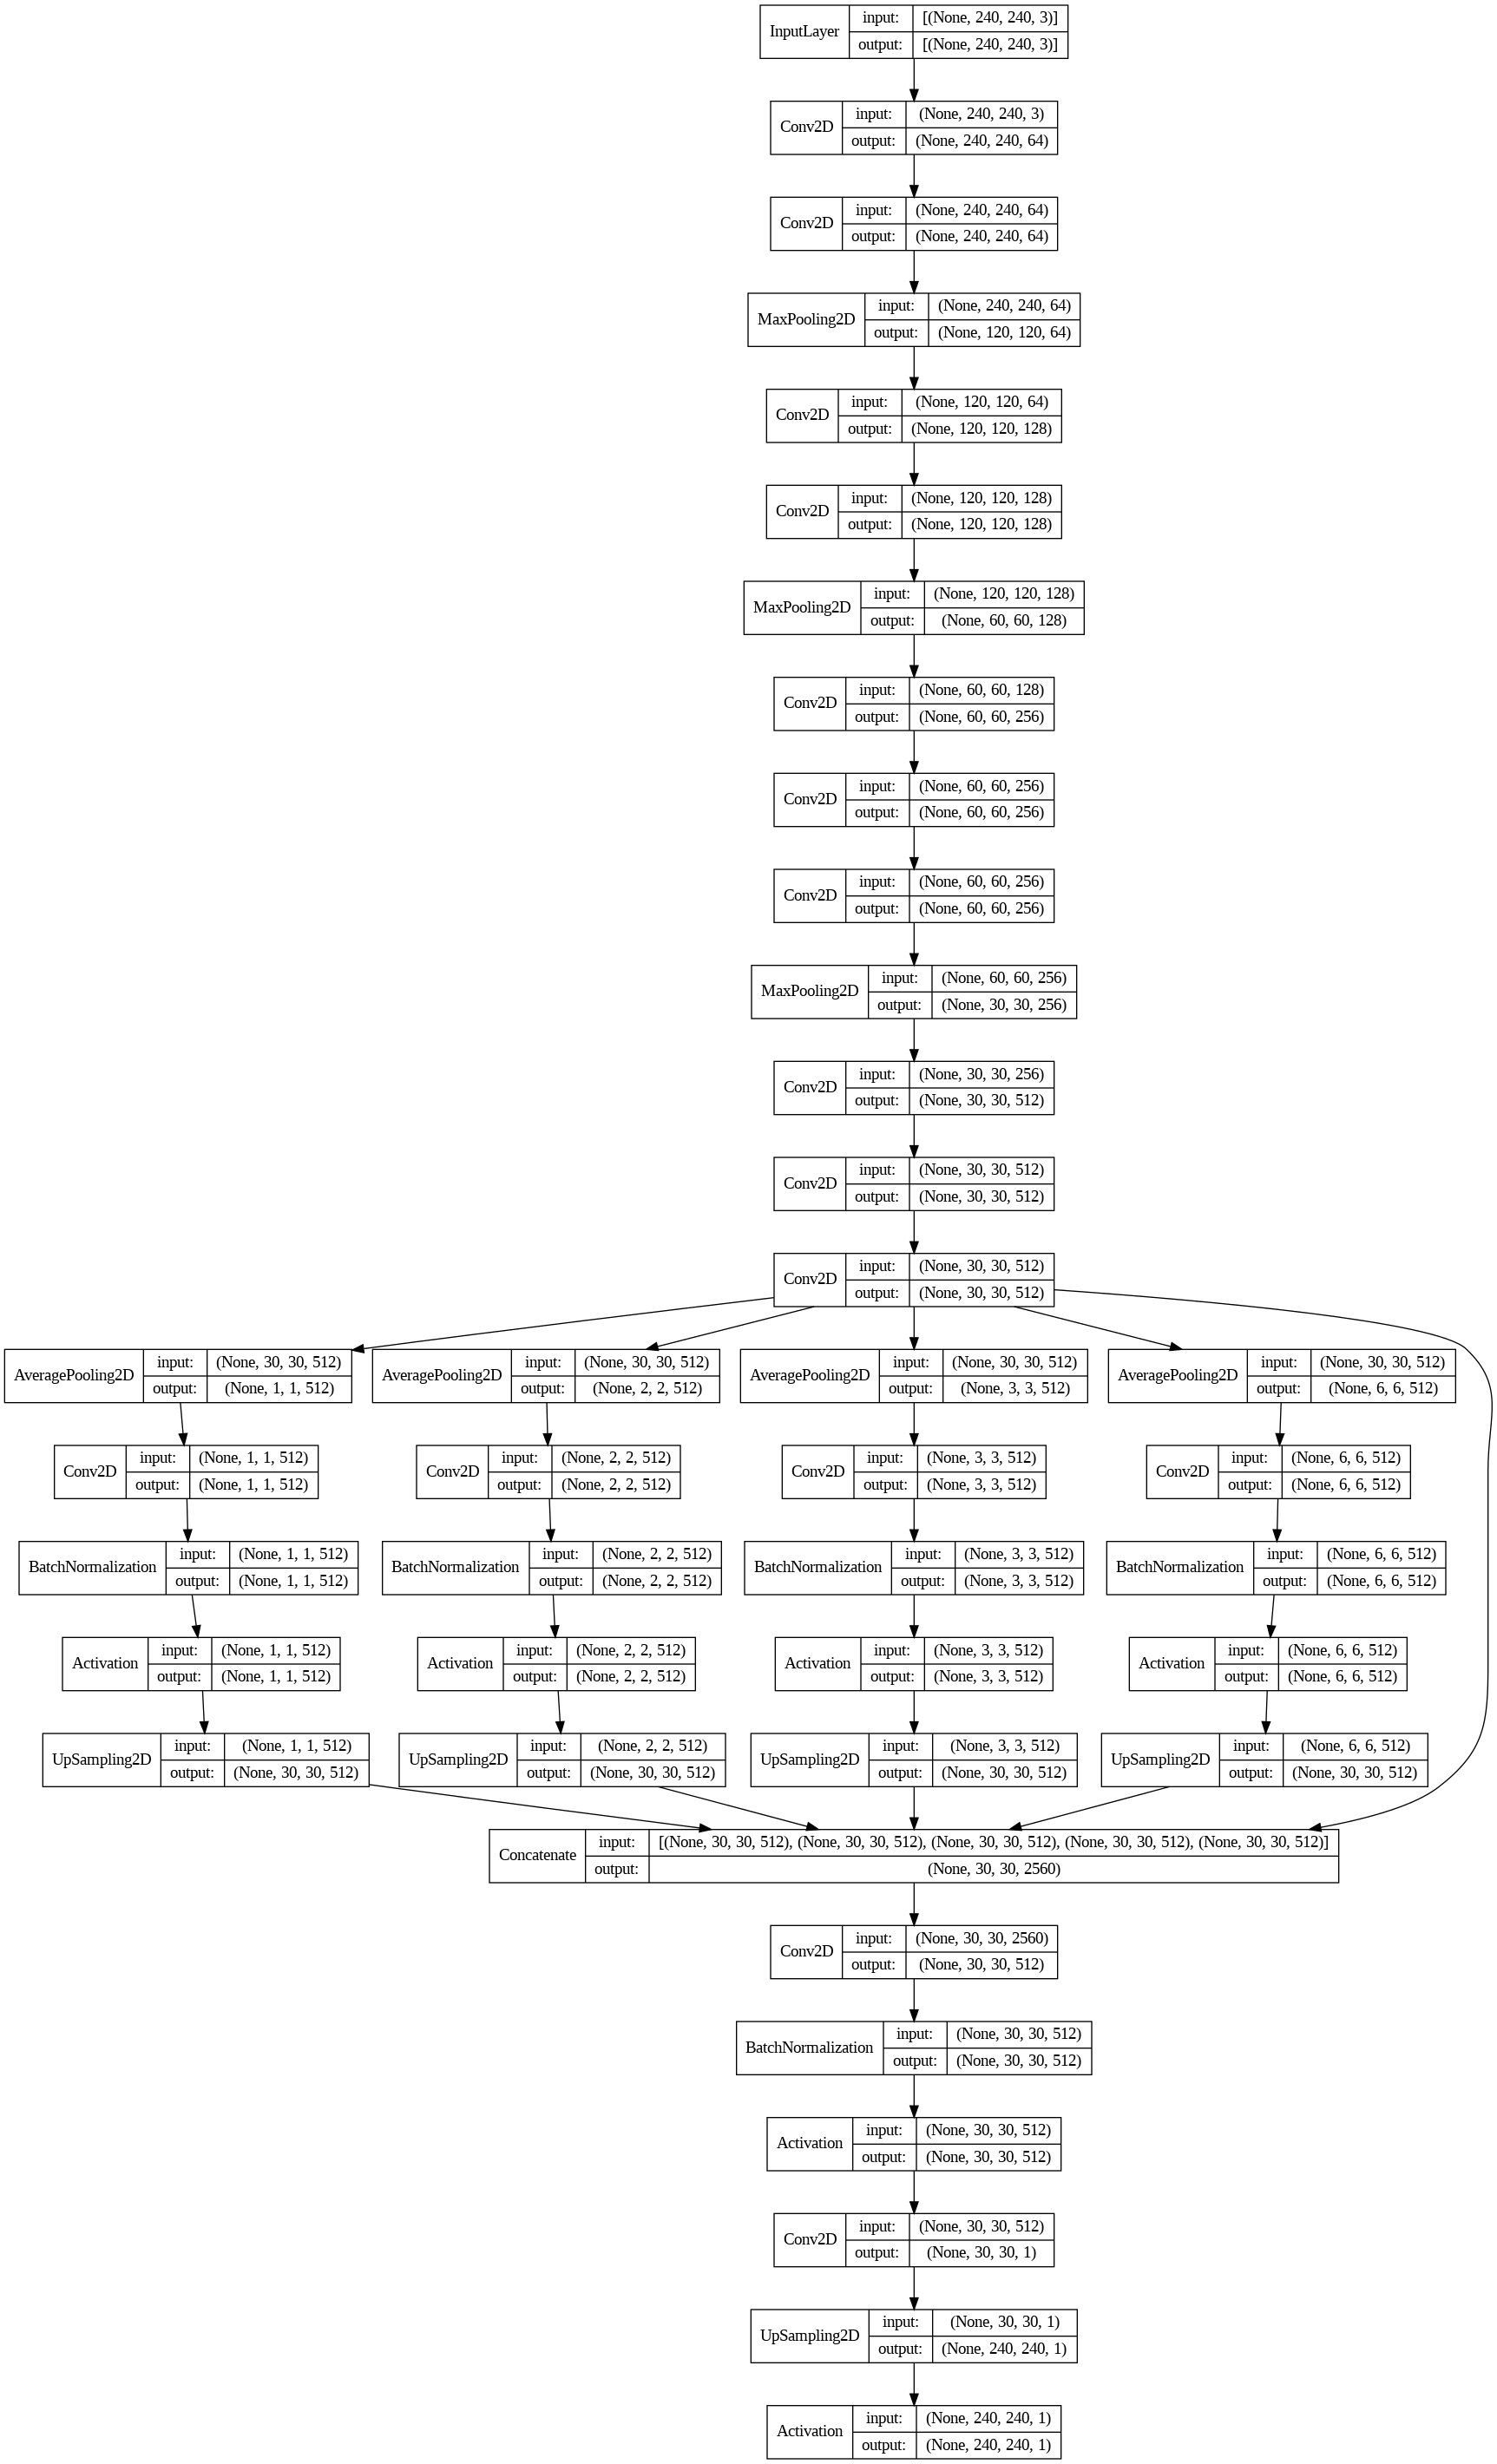

In [ ]:
#img_file = './model_arch.png'
#tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

#file_name='unet_f_model.png'
#file_name='linknet_f_model.png'
#file_name='pspnet_f_model_.png'

from keras.utils.vis_utils import plot_model

tf.keras.utils.plot_model(
  model, to_file = file_name_1, show_shapes=True, show_dtype=False,
  show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96
)

#model: A Keras model instance
#to_file: File name of the plot image.
#show_shapes: whether to display shape information.
#show_layer_names: whether to display layer names.
#rankdir: rankdir argument passed to PyDot, a string specifying the format of the plot: 'TB' creates a vertical plot; 'LR' creates a horizontal plot.


# Plot model

## Install tensorflow 2.6.4

In [ ]:
!pip install tensorflow==2.6.4
import tensorflow as tf
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.3/464.3 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.9/462.9 KB 46.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 82.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 22.7 MB/s eta 0:00:00
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=00aa4c0e3be45965340f8f153a34249d4509c6227523a2b524aefe

## Install pydotplus

In [ ]:
pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Install graphviz

In [ ]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Clone plot_model

In [ ]:
!git clone https://github.com/ryuuzaki42/plot_model

Cloning into 'plot_model'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 92 (delta 42), reused 61 (delta 20), pack-reused 0
Unpacking objects: 100% (92/92), 1.29 MiB | 8.32 MiB/s, done.


## Load/Exec file

In [ ]:
execfile("/content/plot_model/plot_model/plot_model.py")

## Make the plot

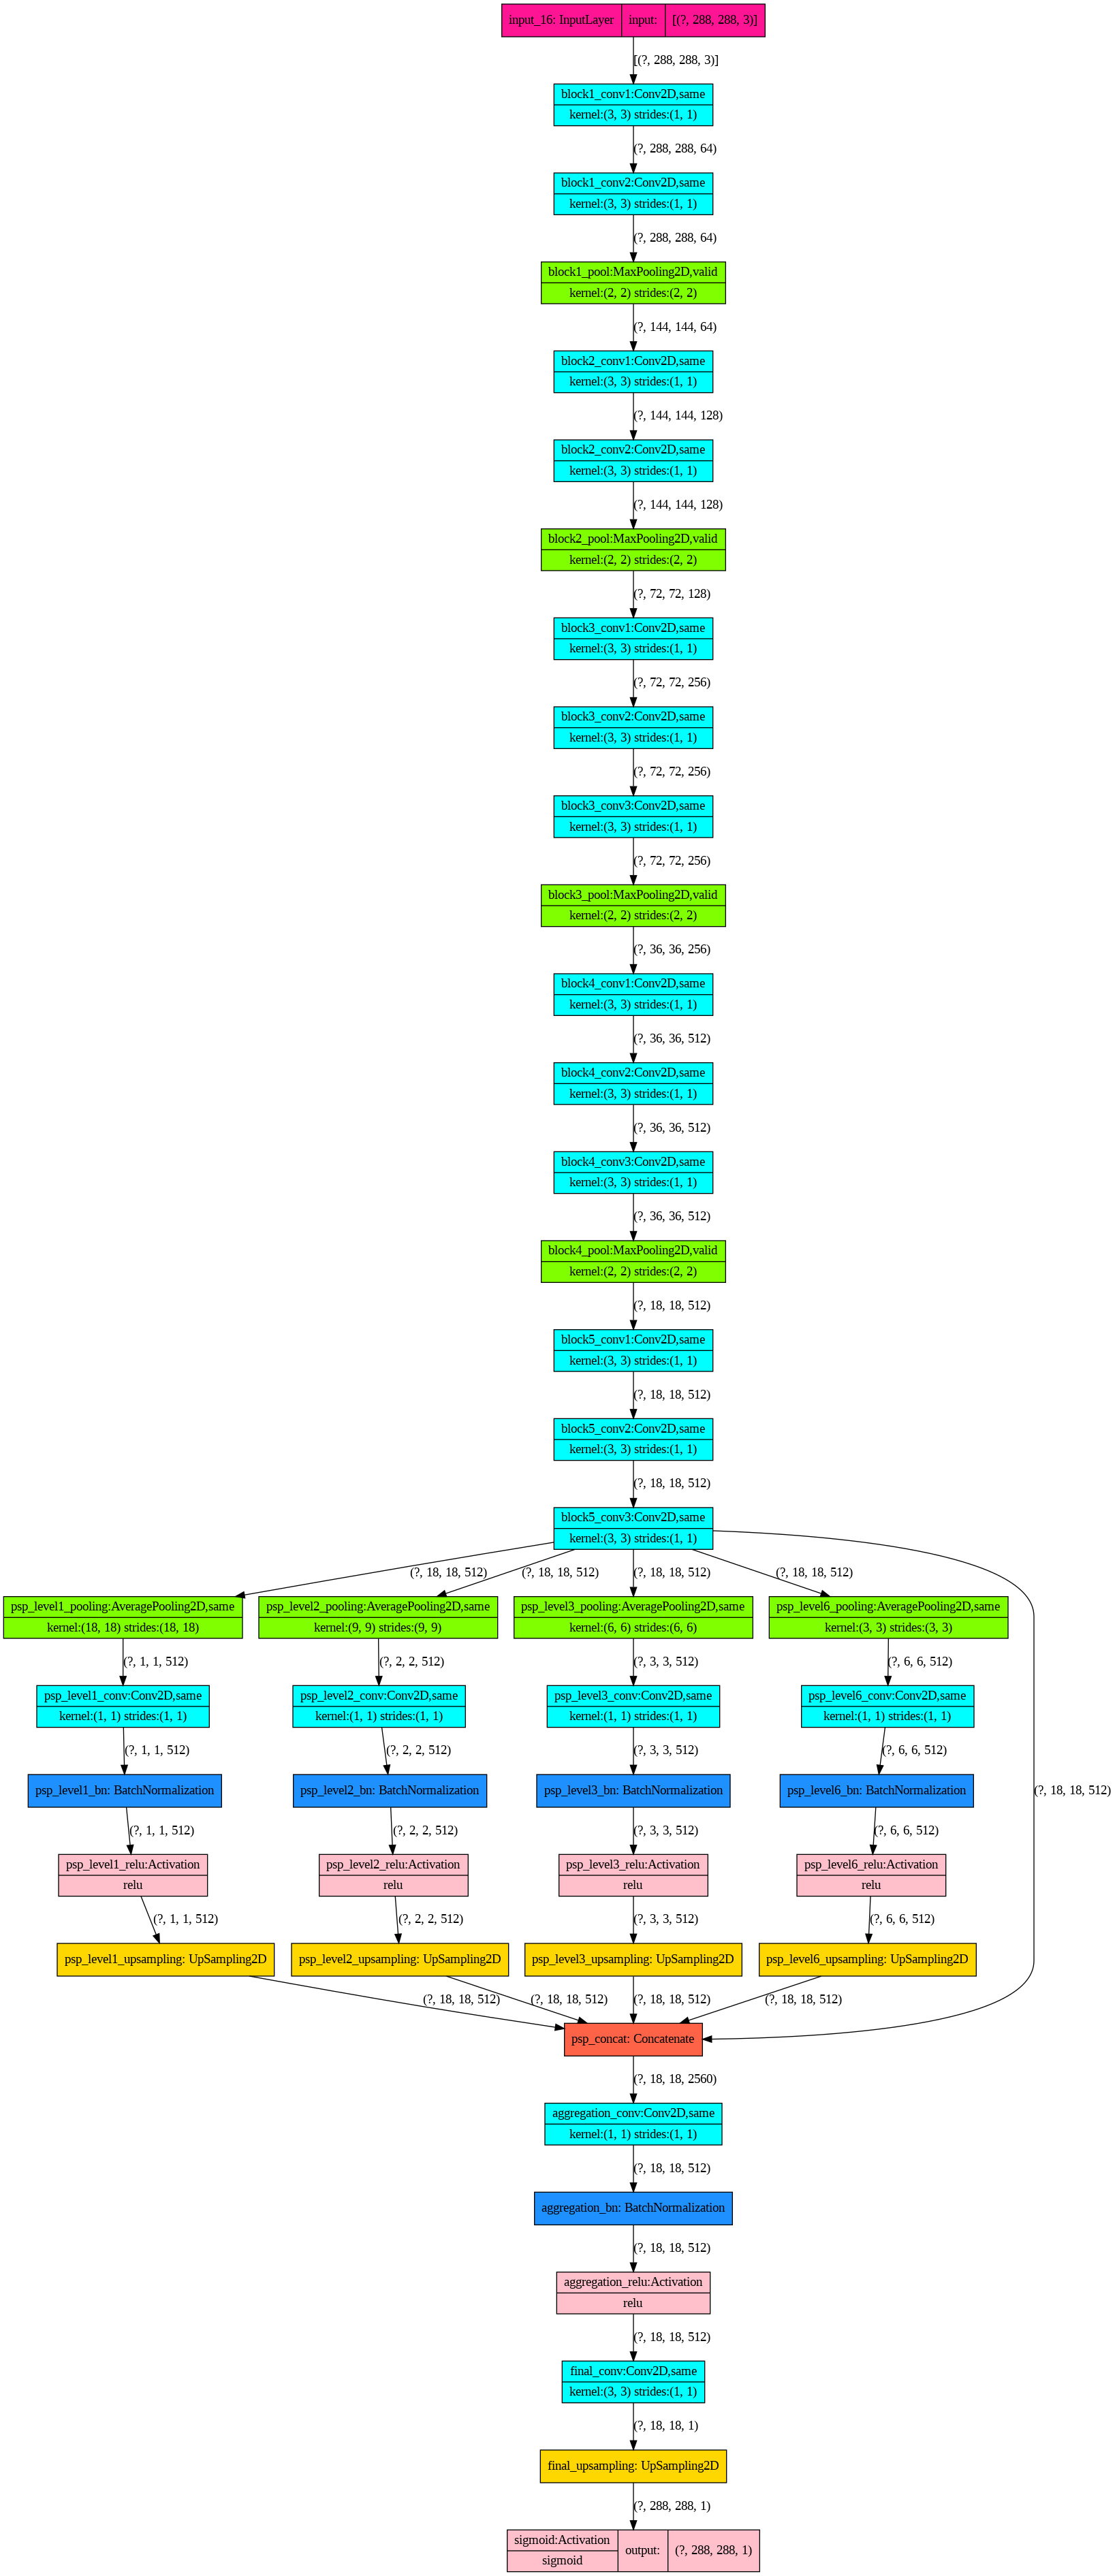

In [ ]:
#file_name='unet_model.png'
#file_name='linknet_model.png'
#file_name='pspnet_model.png'

#plot_model(model)

#Default
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, style=0, color=True, dpi=96)

plot_model(model, to_file = file_name_2, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, style=0, color=True, dpi=96)


In [ ]:
!zip -r models.zip models/

In [ ]:
!zip -r pspnet_models.zip pspnet_models/

  adding: pspnet_models/ (stored 0%)
  adding: pspnet_models/.ipynb_checkpoints/ (stored 0%)
  adding: pspnet_models/pspnet_f_model_8.png (deflated 13%)
  adding: pspnet_models/pspnet_f_model_16.png (deflated 13%)
  adding: pspnet_models/pspnet_f_model_4.png (deflated 12%)
  adding: pspnet_models/pspnet_model_8.png (deflated 25%)
  adding: pspnet_models/pspnet_model_4.png (deflated 18%)
  adding: pspnet_models/pspnet_model_16.png (deflated 25%)


In [ ]:
!pwd
%cd "/content/drive/MyDrive"
!pwd

#!ls

#!mv "C_000"*".png" z/
!mv "C_0"*".png" z/
!mv "C_1"*".png" z/
!mv "C_2"*".png" z/

%cd "/content/drive/MyDrive/z/"
!rm "C_0"*".png"
!rm "C_1"*".png"
!rm "C_2"*".png"